In [1]:
class Particle:
    def __init__(self, particleText, METPhi):
        
        #Get our list of quantities for the particle
        particleInfo = particleText.split(",")
        
        #Define our particle quantities
        self.obj = particleInfo[0]
        self.E = float(particleInfo[1])
        self.pt = float(particleInfo[2])
        self.eta = float(particleInfo[3])
        self.phi = float(particleInfo[4])
        self.deltaPhi = abs(self.phi-METPhi)
        
    def __str__(self):
        return "(obj: " + self.obj + ", E: " + str(self.E) + ", pt: " + str(self.pt) + ", eta: " + str(self.eta) + ", phi: " +str(self.phi) + ")"
    
    def getQuantity(self, quantityType):
        
        if quantityType == "E":
            return self.E
        
        elif quantityType == "pt":
            return self.pt
        
        elif quantityType == "eta":
            return self.eta
        
        elif quantityType == "phi":
            return self.phi
        
        elif quantityType == "deltaPhi":
            return self.deltaPhi
        
        else:
            print("Error: Invalid quantity type")
            return 0.0
        
    __repr__=__str__

In [2]:
import sklearn.discriminant_analysis as DA
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import random
from keras.models import Sequential
from keras.layers import Dense
from keras.models import Model
from keras.layers import Dense, Input
from keras.activations import relu

In [3]:
def makeMatrixValues(ptList, pxSquaredList, pySquaredList, pxpyList):
    
    #Create the values to put in our momentum matrix
    ptSum = sum(ptList)
    pxSquaredSum = sum(pxSquaredList)/ptSum
    pySquaredSum = sum(pySquaredList)/ptSum
    pxpySum = sum(pxpyList)/ptSum
    
    return pxSquaredSum, pySquaredSum, pxpySum

In [4]:
def createMatrix(ptList, pxSquaredList, pySquaredList, pxpyList):
    
    #Create the values to put in our momentum matrix
    pxSquaredSum, pySquaredSum, pxpySum = makeMatrixValues(ptList, pxSquaredList, pySquaredList, pxpyList)
    
    #Create the momentum matrix
    pMatrix = [[pxSquaredSum, pxpySum], [pxpySum, pySquaredSum]]
    
    return pMatrix

In [5]:
def getEigenValues(ptList, pxSquaredList, pySquaredList, pxpyList):
    
    #Create the momentum matrix
    pMatrix = createMatrix(ptList, pxSquaredList, pySquaredList, pxpyList)
    
    #Get the eigenvalues of our momentum matrix. We will use these eigenvalues to calculate transverse sphericity
    eigenValues, eigenVectors = np.linalg.eig(pMatrix)
    
    return eigenValues

In [6]:
def computeSTFromEigenValues(eigenValues):
    
    #Define the eigenvalues needed to calculate transverse sphericity
    eigenValue1 = max(eigenValues)
    eigenValue2 = min(eigenValues)
    
    ST = 2.0*eigenValue2/(eigenValue1+eigenValue2)
    
    return ST

In [7]:
def getPValues(particle):
    
    #Get the particle quantities needed to get these values
    pt = particle.pt
    phi = particle.phi
    
    #Get the x and y components of momentum
    px = pt*np.cos(phi)
    py = pt*np.sin(phi)
    
    #These are values needed to create the momentum matrix to calcule transverse sphericity
    pxSquared = px**2/pt
    pySquared = py**2/pt
    pxpy = px*py/pt
    
    return pt, pxSquared, pySquared, pxpy

In [8]:
def checkJets(obj):
    return obj in ["j", "b"]

def checkLeptons(obj):
    return obj in ["e-", "e+", "m-", "m+"]

def checkPhotons(obj):
    return obj=="g"

In [9]:
def calculateST(ptList, pxSquaredList, pySquaredList, pxpyList):
    
    #Make the matrix and get the eigenvalues needed to calculate ST
    eigenValues = getEigenValues(ptList, pxSquaredList, pySquaredList, pxpyList)
    
    ST = computeSTFromEigenValues(eigenValues)
    
    return ST

In [10]:
def makeFeatures(MET, METPhi, eventInfo):
    
    #total number of datapoints in the line
    length = len(eventInfo)
    
    # define quantitity lists needed for calculating transverse sphericity
    particleList = []
    pxSquaredList = []
    pySquaredList = []
    pxpyList = []
    ptList = []
    deltaPhiList = []
    
    #Define the absolute sum of transverse momentum to calculate Meff
    absolutePtSum = 0.0
    leadingPt = 0.0
    
    #Define the count for the various particle types
    jets = 0
    leptons = 0
    photons = 0
    
    #Increment over all of the particles in the line
    for i in range(5, length):
        
        #Get the text for the particle
        particleText = eventInfo[i]
        
        #Make sure that it is actually information for the particle
        if particleText != "" and particleText != "\n":
            
            particle = Particle(particleText, METPhi)
            
            #get the type of particle
            obj = particle.obj
            
            #count the particles of each type
            if checkJets(obj):
                jets += 1
                
            elif checkLeptons(obj):
                leptons += 1
                
            elif checkPhotons(obj):
                photons += 1
            
            #Get the momentum-derived values needed to calulate features
            pt, pxSquared, pySquared, pxpy = getPValues(particle)
            
            if pt > leadingPt:
                leadingPt = pt
            
            pxSquaredList.append(pxSquared)
            pySquaredList.append(pySquared)
            pxpyList.append(pxpy)
            ptList.append(pt)
            
            absolutePtSum += abs(pt)
            
            particleList.append(particle)
            deltaPhiList.append(particle.deltaPhi)
    
    ST = calculateST(ptList, pxSquaredList, pySquaredList, pxpyList)
    
    Meff = MET + absolutePtSum
    
    return particleList, jets, leptons, photons, Meff, ST, leadingPt, ptList, deltaPhiList

In [11]:
def makeEvent(line, signal):
    
    eventInfo = line.split(";")
    
    eventID = eventInfo[0]
    processID = eventInfo[1]
    eventWeight = float(eventInfo[2])
    MET = float(eventInfo[3])
    METPhi = float(eventInfo[4])
    
    signal = float(signal)
    
    particleList, jets, leptons, photons, Meff, ST, leadingPt, ptList, deltaPhiList = makeFeatures(MET, METPhi, eventInfo)
    
    crossSection = 1.0
    
    event = {
        "eventID" : eventID,
        "processID" : processID,
        "eventWeight" : eventWeight,
        "MET" : MET,
        "METPhi" : METPhi,
        "particleList" : particleList,
        "jets" : jets,
        "leptons" : leptons,
        "photons" : photons,
        "crossSection" : crossSection,
        "Meff" : Meff,
        "ST" : ST,
        "leadingPt" : leadingPt,
        "ptList" : ptList,
        "deltaPhiList" : deltaPhiList,
        "signal" : signal
    }
    
    return event

In [12]:
def calculateSignalCrossSection(event, length):
    
    eventWeight = event["eventWeight"]
    
    crossSection = eventWeight*length
    
    return crossSection

In [13]:
def calculateBackgroundCrossSection(length, luminosity):
    
    crossSection = length/luminosity
    
    return crossSection

In [14]:
def calculateCrossSection(event, length, luminosity, signal):
    if signal:
        return calculateSignalCrossSection(event, length)
    else:
        return calculateBackgroundCrossSection(length, luminosity)

In [15]:
def makeDataList(filePath, signal, luminosity = 1.0):
    
    file = open(filePath, "r")
    
    dataList = []
    
    for line in file:
        
        event = makeEvent(line, signal)
        
        dataList.append(event)

    file.close()
    
    length = float(len(dataList))
    
    for event in dataList:
        
        event["crossSection"] = calculateCrossSection(event, length, luminosity, signal)
    
    
    return dataList

In [16]:
backgroundDataList = makeDataList("Data/training_files/training_files/chan1/background_chan1_7.79.csv", False, luminosity = 7.79)
signalDataList = makeDataList("Data/training_files/training_files/chan1/glgl1400_neutralino1100_chan1.csv", True)

In [17]:
print(len(backgroundDataList))
print(len(signalDataList))
print(backgroundDataList[0]["signal"])
print(signalDataList[0]["signal"])

214185
4096
0.0
1.0


In [18]:
N_Train=2000

trainBackgroundDataList = backgroundDataList[:N_Train]
testBackgroundDataList = backgroundDataList[N_Train:]

trainSignalDataList = signalDataList[:N_Train]
testSignalDataList = signalDataList[N_Train:]

trainDataList = trainBackgroundDataList + trainSignalDataList
testDataList = testBackgroundDataList + testSignalDataList

random.shuffle(trainDataList)
random.shuffle(testDataList)

In [19]:
Train_Sample = pd.DataFrame(data = trainDataList)
Test_Sample = pd.DataFrame(data = testDataList)

VarNames = ["MET", "METPhi", "jets", "leptons", "photons", "Meff", "ST", "leadingPt"]

X_Train = Train_Sample[VarNames]
y_Train = Train_Sample["signal"]

X_Test = Test_Sample[VarNames]
y_Test = Test_Sample["signal"]

Test_sig = Test_Sample[Test_Sample.signal == 1]
Test_bkg = Test_Sample[Test_Sample.signal == 0]

In [20]:
Fisher = DA.LinearDiscriminantAnalysis()

In [21]:
Fisher.fit(X_Train, y_Train)

LinearDiscriminantAnalysis()

In [22]:
Fisher.predict(X_Test)

array([0., 1., 0., ..., 0., 1., 0.])

In [23]:
def normalizeArea(hist, bin_edges):
    
    bin_size = bin_edges[1] - bin_edges[0]
    integral = sum(hist) * bin_size
    normalizedCount = (1.0/integral) * hist
    
    return normalizedCount

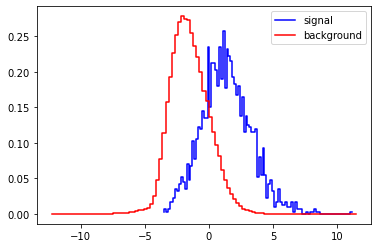

In [24]:
plt.figure()
sigHist, sig_bin_edges = np.histogram(Fisher.decision_function(Test_sig[VarNames]), bins=100)
normalizedSigHist = normalizeArea(sigHist, sig_bin_edges)
bkgHist, bkg_bin_edges = np.histogram(Fisher.decision_function(Test_bkg[VarNames]), bins=100)
normalizedBkgHist = normalizeArea(bkgHist, bkg_bin_edges)
plt.step(sig_bin_edges[1:], normalizedSigHist, label="signal", color = "blue")
plt.step(bkg_bin_edges[1:], normalizedBkgHist, label="background", color = "red")
#plt.hist(Fisher.decision_function(Test_sig[VarNames]),bins=100,histtype="step", color="blue", label="signal",stacked=True)
#plt.hist(Fisher.decision_function(Test_bkg[VarNames]),bins=100,histtype="step", color="red", label="background",stacked=True)
plt.legend(loc='upper right')
plt.show()

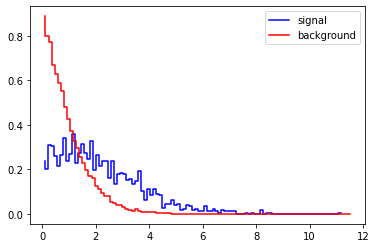

In [25]:
plt.figure()
sig_pred = Test_sig[np.array(Fisher.predict(Test_sig[VarNames]),dtype="bool")]
sigHist, sig_bin_edges = np.histogram(Fisher.decision_function(sig_pred[VarNames]), bins=100)
normalizedSigHist = normalizeArea(sigHist, sig_bin_edges)
#plt.hist(Fisher.decision_function(sig_pred[VarNames]),bins=100,histtype="step", color="blue", label="signal",stacked=True)
plt.step(sig_bin_edges[1:], normalizedSigHist, label="signal", color = "blue")
bkg_pred = Test_bkg[np.array(Fisher.predict(Test_bkg[VarNames]),dtype="bool")]
bkgHist, bkg_bin_edges = np.histogram(Fisher.decision_function(bkg_pred[VarNames]), bins=100)
normalizedBkgHist = normalizeArea(bkgHist, bkg_bin_edges)
plt.step(bkg_bin_edges[1:], normalizedBkgHist, label="background", color = "red")
#plt.hist(Fisher.decision_function(bkg_pred[VarNames]),bins=100,histtype="step", color="red", label="background",stacked=True)
plt.legend(loc='upper right')
plt.show()

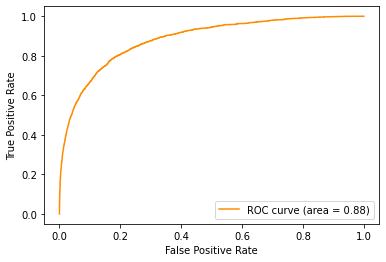

In [26]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_Test, Fisher.decision_function(X_Test))

roc_auc = auc(fpr, tpr)

plt.plot(fpr,tpr,color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()

In [27]:
model = Sequential()
model.add(Dense(12, input_dim=X_Train.shape[1], activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                108       
                                                                 
 dense_1 (Dense)             (None, 8)                 104       
                                                                 
 dense_2 (Dense)             (None, 8)                 72        
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 293
Trainable params: 293
Non-trainable params: 0
_________________________________________________________________


In [29]:
in_x = Input(shape = X_Train.shape[1:])
x = Dense(12, input_dim=X_Train.shape[1], activation='relu')(in_x)
x = Dense(8, activation='relu')(x)
x = Dense(8, activation='relu')(x)
out_x = Dense(1, activation='sigmoid')(x)

model = Model(in_x,out_x)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense_4 (Dense)             (None, 12)                108       
                                                                 
 dense_5 (Dense)             (None, 8)                 104       
                                                                 
 dense_6 (Dense)             (None, 8)                 72        
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 293
Trainable params: 293
Non-trainable params: 0
_________________________________________________________________


In [30]:
in_x = Input(shape = X_Train.shape[1:])
x = Dense(12, input_dim=X_Train.shape[1], activation='relu')(in_x)
x = Dense(8)(x)
x = relu(x)
out_x = Dense(1, activation='sigmoid')(x)

model = Model(in_x,out_x)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense_8 (Dense)             (None, 12)                108       
                                                                 
 dense_9 (Dense)             (None, 8)                 104       
                                                                 
 tf.nn.relu (TFOpLambda)     (None, 8)                 0         
                                                                 
 dense_10 (Dense)            (None, 1)                 9         
                                                                 
Total params: 221
Trainable params: 221
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [32]:
history=model.fit(X_Train, y_Train, validation_data=(X_Test,y_Test), epochs=10, batch_size=2048)

Epoch 1/10
2/2 [==============================] - 2s 735ms/step - loss: 17356.7637 - accuracy: 0.5000 - val_loss: 28535.7207 - val_accuracy: 0.0098
Epoch 2/10
2/2 [==============================] - 0s 341ms/step - loss: 13661.4043 - accuracy: 0.5000 - val_loss: 21376.5527 - val_accuracy: 0.0098
Epoch 3/10
2/2 [==============================] - 0s 326ms/step - loss: 10053.1318 - accuracy: 0.5000 - val_loss: 14376.3965 - val_accuracy: 0.0098
Epoch 4/10
2/2 [==============================] - 0s 338ms/step - loss: 6490.9048 - accuracy: 0.4992 - val_loss: 7577.0278 - val_accuracy: 0.0375
Epoch 5/10
2/2 [==============================] - 0s 327ms/step - loss: 3566.7405 - accuracy: 0.3745 - val_loss: 2321.7751 - val_accuracy: 0.3851
Epoch 6/10
2/2 [==============================] - 0s 348ms/step - loss: 3401.1226 - accuracy: 0.3330 - val_loss: 405.9639 - val_accuracy: 0.7949
Epoch 7/10
2/2 [==============================] - 0s 337ms/step - loss: 4647.1401 - accuracy: 0.4338 - val_loss: 155.64

In [33]:
print (history.history)

{'loss': [17356.763671875, 13661.404296875, 10053.1318359375, 6490.90478515625, 3566.740478515625, 3401.12255859375, 4647.14013671875, 5119.97705078125, 4547.48681640625, 3419.081298828125], 'accuracy': [0.5, 0.5, 0.5, 0.49924999475479126, 0.37450000643730164, 0.3330000042915344, 0.4337500035762787, 0.47350001335144043, 0.45750001072883606, 0.39524999260902405], 'val_loss': [28535.720703125, 21376.552734375, 14376.396484375, 7577.02783203125, 2321.775146484375, 405.9638977050781, 155.64169311523438, 165.09640502929688, 405.2961730957031, 1362.70361328125], 'val_accuracy': [0.009781548753380775, 0.009781548753380775, 0.009781548753380775, 0.037483491003513336, 0.3851017951965332, 0.7949468493461609, 0.9306098222732544, 0.9173141717910767, 0.7781977653503418, 0.4798652231693268]}


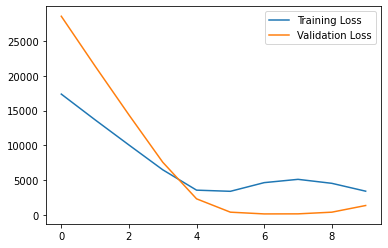

In [34]:
plt.plot(range(len(history.history["loss"])),history.history["loss"],label="Training Loss")
plt.plot(range(len(history.history["val_loss"])),history.history["val_loss"],label="Validation Loss")
plt.legend()

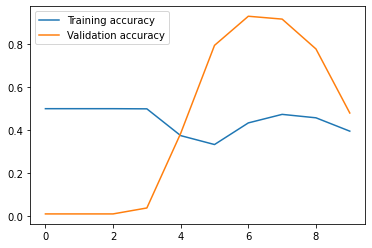

In [35]:
plt.plot(range(len(history.history["accuracy"])),history.history["accuracy"],label="Training accuracy")
plt.plot(range(len(history.history["val_accuracy"])),history.history["val_accuracy"],label="Validation accuracy")
plt.legend()

In [36]:
scores = model.evaluate(X_Test, y_Test)
print(scores)

6697/6697 [==============================] - 18s 3ms/step - loss: 1362.7035 - accuracy: 0.4799
[1362.7034912109375, 0.4798652231693268]


In [37]:
model.predict(X_Test)

6697/6697 [==============================] - 16s 2ms/step


array([[1.],
       [0.],
       [1.],
       ...,
       [1.],
       [0.],
       [1.]], dtype=float32)

6697/6697 [==============================] - 16s 2ms/step


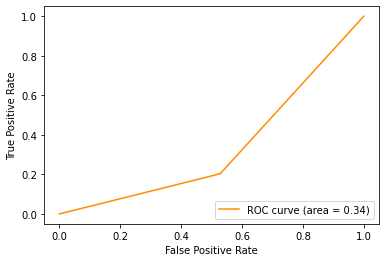

In [38]:
fpr, tpr, _ = roc_curve(y_Test, model.predict(X_Test))
                        
roc_auc = auc(fpr, tpr)

plt.plot(fpr,tpr,color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()